<a href="https://colab.research.google.com/github/JorgeRR89/CTR/blob/main/Module_15_Ensemble_Learning_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module Import

In [1]:
!pip install xgboost==1.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.9/192.9 MB 2.8 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.1
    Uninstalling xgboost-3.1.1:
      Successfully uninstalled xgboost-3.1.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset Import

In [3]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

The overall dataset has already been split into 70% train and 30% test datasets.

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MIT XPro/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MIT XPro/test.csv")

In [ ]:
train_df.head()

In [ ]:
y_train = train_df.pop('CTR')
y_test = test_df.pop('CTR')

# Helper Functions

We will use some functions to evaluate results:


*   MAE (mean absolute error)
*   RMSE (root mean squared error)
*   OSR2 (out of sample R2)

We will apply these to the test set always so that our metrics are out-of-sample

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def OSR2(y_true, y_pred, training_mean):
  '''
  Calculates out-of-sample R-squared
  '''
  baseline_error = np.sum(np.square((training_mean - y_true)))
  model_error = np.sum(np.square((y_pred - y_true)))
  return 1.0 - model_error/baseline_error


def calc_metrics():
  print(f'OSR2: {OSR2(y_test, y_pred, y_train.mean()):.3f}')
  print(f'MAE: {mean_absolute_error(y_test, y_pred):.3f}')
  print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')


# Linear Regression

In [ ]:
train = train_df.copy()
test = test_df.copy()
train = pd.get_dummies(train, columns=['age','gender'], drop_first=True)
test = pd.get_dummies(test, columns=['age','gender'], drop_first=True)

In [ ]:
train.head()

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train, y_train)
y_pred = model.predict(test)
calc_metrics()

In [ ]:
pd.DataFrame({"Variable": train.columns, "Coefficient": model.coef_})

# CART for Regression

In [ ]:
train = train_df.copy()
test = test_df.copy()
train = pd.get_dummies(train, columns=['age','gender'])
test = pd.get_dummies(test, columns=['age','gender'])

In [ ]:
from sklearn.tree import DecisionTreeRegressor

Let's train a full tree first.

In [ ]:
tree = DecisionTreeRegressor(random_state=42).fit(train,y_train)
y_pred = tree.predict(test)
calc_metrics()

Really bad!

In [ ]:
tree = DecisionTreeRegressor(random_state=42)
path = tree.cost_complexity_pruning_path(train, y_train)

In [ ]:
alphas = path.ccp_alphas

In [ ]:
alphas[-10:]

In [ ]:
len(alphas)

That's a lot of possible pruned trees. Let's select every 10th tree so that we get ~330 trees in total.

In [ ]:
alphas = alphas[::10]

In [ ]:
len(alphas)

In [ ]:
osr2_all = []

for alpha in alphas:
  tree = DecisionTreeRegressor(ccp_alpha=alpha, random_state=42).fit(train,y_train)
  y_pred = tree.predict(test)
  osr2 = OSR2(y_test, y_pred, y_train.mean())
  osr2_all.append(osr2)

What's the best OSR2?

In [ ]:
np.max(osr2_all)

Nice improvement!

In [ ]:
opt_alpha = alphas[np.argmax(osr2_all)]

In [ ]:
tree = DecisionTreeRegressor(ccp_alpha=opt_alpha, random_state=42).fit(train,y_train)
y_pred = tree.predict(test)
calc_metrics()

Very nice!

How big is this tree?

In [ ]:
tree.tree_.node_count, tree.tree_.max_depth

In [ ]:
from sklearn.tree import plot_tree

In [ ]:
def viz_tree(tree, X, font=12, figsize=(16,10)):
  '''
  draws a CART tree
  '''
  plt.figure(figsize=figsize)  # set plot size (denoted in inches)
  _ = plot_tree(tree,
                feature_names=X.columns,
                filled=True,
                fontsize=font)

In [ ]:
viz_tree(tree, train, figsize=(36,10))

# Random Forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor

Let's train a Random Forest model with all default settings.

In [ ]:
rf = RandomForestRegressor(random_state=42).fit(train,y_train)
y_pred = rf.predict(test)
calc_metrics()

That handily outperforms Linear Regression and CART.

# XGBoost!

In [ ]:
import xgboost
print(xgboost.__version__)

In [ ]:
from xgboost import XGBRegressor

In [ ]:
model = XGBRegressor(random_state=42)

Let's train an XGBoost model with all default settings.

In [ ]:
model.fit(train, y_train)
y_pred = model.predict(test)

In [ ]:
calc_metrics()

# Hyperparameter Optimization

## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

Let's vary *three* hyperparameters simultaneously:

*   number of trees `n_estimators`: 10, 50, 100
*   maximum depth of the tree `max_depth`: 1,2,3,4,5
*   learning rate/shrinkage parameter $\eta$ i.e., `learning_rate`: 0.001, 0.01, 0.1, 0.3

This generates 60 hyperparameter combinations. For each, we will do 5-fold CV. So, an XGBoost model will be trained 300 times!



In [ ]:
param_grid = {'n_estimators': [10,50,100],
              'max_depth': [1,2,3,4,5],
              'learning_rate': [0.001, 0.01, 0.1, 0.3]}

In [ ]:
model = XGBRegressor(random_state=42)

In [ ]:
gcv = GridSearchCV(model,
                  param_grid=param_grid,
                  cv=5,
                  scoring='neg_mean_absolute_error')

In [ ]:
gcv.fit(train, y_train)

What's the combination with the lowest MAE?

In [ ]:
gcv.best_params_

In [ ]:
y_pred = gcv.best_estimator_.predict(test)
calc_metrics()

## Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
model = XGBRegressor(random_state=42)

In [ ]:
param_grid = {'n_estimators': range(10,1010,10),
              'max_depth': range(1,21),
              'learning_rate': np.linspace(0.001, 1.0, 50)}

**That**'s 100 x 20 x 50 = 100,000 combinations! We will try only 10 of these combinations using `RandomizedSearch`.

In [ ]:
rcv = RandomizedSearchCV(model,
                        param_distributions = param_grid,
                        cv=5,
                        n_iter=10,
                        scoring='neg_mean_absolute_error',
                        random_state=42)

In [ ]:
rcv.fit(train, y_train)

In [ ]:
rcv.best_params_

In [ ]:
y_pred = rcv.best_estimator_.predict(test)
calc_metrics()



---



---


**SUMMARY**

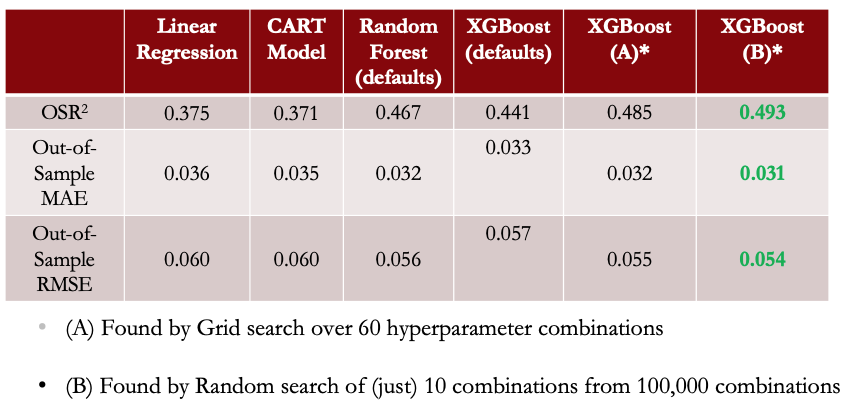



---



---



In [ ]:
pd.DataFrame(rcv.cv_results_)

In [ ]:
from xgboost import plot_importance

In [ ]:
plot_importance(rcv.best_estimator_, importance_type='gain', show_values=False, xlabel='');

## Next Steps

We invite you to:

*   try different hyperparameter combinations and improve upon these metrics
*   apply the same techniques – Cross-Validation, Grid Search and Random Search – to find good hyperparameter combinations for Random Forests as well.
